In [310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

import pandas as pd
import statsmodels.api as sm 

def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

def regress_error(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    output = list(result.params)
    output.extend(list(result.bse))
    return pd.Series(output, ["slope", "intercept", "slope_e", "intercept_e"])

sns.set(style="darkgrid", palette="Set2") 

# All plates at once:

In [311]:
# plate 1
df = pl.read_csv("growth_data/adrian_growth_jan25_v2.csv")
df = df.drop('T600')

# time conversion
df = df.with_columns(pl.col("Time").str.to_time("%H:%M:%S"))
df = df.with_columns(3600 * df['Time'].dt.hour().cast(pl.Int64) + 60 * df['Time'].dt.minute().cast(pl.Int64) + df['Time'].dt.second())

# zero by first measurement
df = df.with_columns([pl.col(c) - df[0, c] for c in df.columns])

# melt to experiments
df = df.melt(id_vars="Time", variable_name="Well", value_name="OD")
df = df.with_columns((df["Well"].str.slice(0,1)).alias("Experiment"))
df = df.with_columns((df["Well"].str.slice(1)).alias("Replicate"))
df = df.with_columns(Plate = pl.lit("Plate 1"))

# plate 1
df2 = pl.read_csv("growth_data/cyrus_012624.csv")
df2 = df2.drop('T600')

# time conversion
df2 = df2.with_columns(pl.col("Time").str.to_time("%H:%M:%S"))
df2 = df2.with_columns(3600 * df2['Time'].dt.hour().cast(pl.Int64) + 60 * df2['Time'].dt.minute().cast(pl.Int64) + df2['Time'].dt.second())

# zero by first measurement
df2 = df2.with_columns([pl.col(c) - df2[0, c] for c in df2.columns])

# melt to experiments
df2 = df2.melt(id_vars="Time", variable_name="Well", value_name="OD")
df2 = df2.with_columns((df2["Well"].str.slice(0,1)).alias("Experiment"))
df2 = df2.with_columns((df2["Well"].str.slice(1)).alias("Replicate"))
df2 = df2.with_columns(Plate = pl.lit("Plate 2"))

df = pl.concat([df, df2])
df

Time,Well,OD,Experiment,Replicate,Plate
i64,str,f64,str,str,str
0,"""A2""",0.0,"""A""","""2""","""Plate 1"""
300,"""A2""",-0.001,"""A""","""2""","""Plate 1"""
600,"""A2""",0.0,"""A""","""2""","""Plate 1"""
900,"""A2""",0.001,"""A""","""2""","""Plate 1"""
1200,"""A2""",0.0,"""A""","""2""","""Plate 1"""
1500,"""A2""",-0.001,"""A""","""2""","""Plate 1"""
1800,"""A2""",-0.001,"""A""","""2""","""Plate 1"""
2100,"""A2""",-0.003,"""A""","""2""","""Plate 1"""
2400,"""A2""",-0.005,"""A""","""2""","""Plate 1"""


In [312]:
# join with experiment type
column_names = ["Experiment", "Abb", "Description", "Pre-met", "Additive"]
conversion = [["A", "Rrm", "Rich + met, ++met", True, "met"], 
              ["B", "Rr", "Rich - met, ++met", True, "none"], 
              ["C", "RrZ", "Rich - met + Zn, ++met", True, "zinc"], 
              ["D", "Rrb", "Rich - met + B12, ++met", True, "B12"],
              ["E", "rm", "Rich + met, --met", False, "met"],
              ["F", "r", "Rich - met, --met", False, "none"],
              ["G", "rz", "Rich - met, --met", False, "zinc"],
              ["H", "rb", "Rich - met, --met", False, "B12"]]

exp = pl.DataFrame(conversion)
exp.columns = column_names


In [313]:
mdf = df.join(exp, on="Experiment")

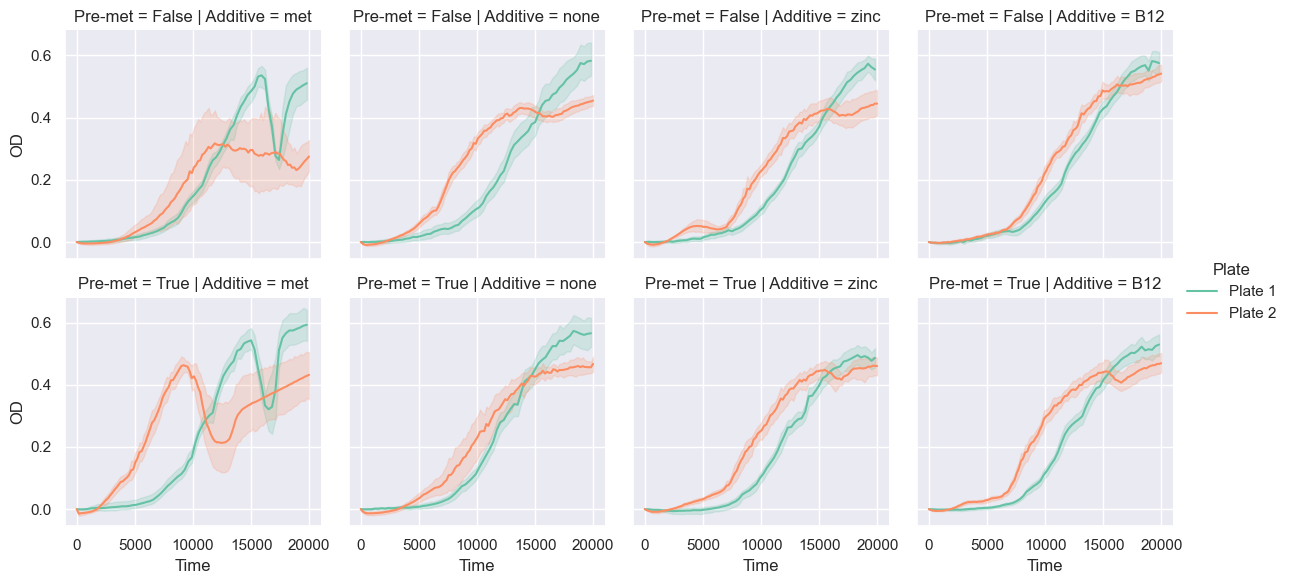

In [314]:
sns.relplot(x="Time", y="OD", hue="Plate", kind="line", row="Pre-met", col="Additive", height=3, \
            data=mdf.filter(
                (pl.col("Time")<20000) & 
                (pl.col("Replicate") != "3")
           ))

In [321]:
growth_rate_precise = data=mdf.filter(
                (pl.col("Time")<40000) 
           )

growth_rate_precise = growth_rate_precise.with_columns(pl.concat_str([pl.col("Well"), pl.col("Plate")], separator=",").alias("Unique_well"))

minimum_start_times = growth_rate_precise.filter(pl.col("OD") <= 0.08).group_by("Unique_well").agg(pl.max("Time").alias("Time_exp_start")).sort("Time_exp_start")
minimum_end_times = growth_rate_precise.filter(pl.col("OD") >= 0.35).group_by("Unique_well").agg(pl.min("Time").alias("Time_exp_end")).sort("Time_exp_end")

growth_rate_precise = growth_rate_precise.join(minimum_start_times, on="Unique_well")
growth_rate_precise = growth_rate_precise.join(minimum_end_times, on="Unique_well")
gr_time_filter = growth_rate_precise.filter((pl.col("Time") > pl.col("Time_exp_start")) & (pl.col("Time") < pl.col("Time_exp_end")))
gr_time_filter = gr_time_filter.with_columns((pl.col("Time") - pl.col("Time_exp_start")).alias("Corrected_time"))

# correct all od values to start at 0
# start_od = gr_time_filter.group_by("Well").agg(pl.min("OD").alias("Start_OD")).sort("Start_OD")
# gr_time_filter = gr_time_filter.join(start_od, on="Well")
# gr_time_filter = gr_time_filter.with_columns((pl.col("OD") - pl.col("Start_OD")).alias("Corrected_OD"))

# correct by linear fit

#This is what you need
correction_offset = gr_time_filter.to_pandas().groupby('Unique_well').apply(regress, 'OD', ['Corrected_time'])
correction_offset = correction_offset.reset_index()
correction_offset = pl.DataFrame(correction_offset)

gr_time_filter = gr_time_filter.join(correction_offset, on="Unique_well")
gr_time_filter = gr_time_filter.with_columns((pl.col("OD") - pl.col("intercept")).alias("Corrected_OD"))

gr_time_filter

Time,Well,OD,Experiment,Replicate,Plate,Abb,Description,Pre-met,Additive,Unique_well,Time_exp_start,Time_exp_end,Corrected_time,Corrected_time_right,intercept,Corrected_OD
i64,str,f64,str,str,str,str,str,bool,str,str,i64,i64,i64,f64,f64,f64
8100,"""A2""",0.083,"""A""","""2""","""Plate 1""","""Rrm""","""Rich + met, ++…",true,"""met""","""A2,Plate 1""",7800,11700,300,0.000076,0.037303,0.045697
8400,"""A2""",0.094,"""A""","""2""","""Plate 1""","""Rrm""","""Rich + met, ++…",true,"""met""","""A2,Plate 1""",7800,11700,600,0.000076,0.037303,0.056697
8700,"""A2""",0.101,"""A""","""2""","""Plate 1""","""Rrm""","""Rich + met, ++…",true,"""met""","""A2,Plate 1""",7800,11700,900,0.000076,0.037303,0.063697
9000,"""A2""",0.113,"""A""","""2""","""Plate 1""","""Rrm""","""Rich + met, ++…",true,"""met""","""A2,Plate 1""",7800,11700,1200,0.000076,0.037303,0.075697
9300,"""A2""",0.131,"""A""","""2""","""Plate 1""","""Rrm""","""Rich + met, ++…",true,"""met""","""A2,Plate 1""",7800,11700,1500,0.000076,0.037303,0.093697
9600,"""A2""",0.152,"""A""","""2""","""Plate 1""","""Rrm""","""Rich + met, ++…",true,"""met""","""A2,Plate 1""",7800,11700,1800,0.000076,0.037303,0.114697
9900,"""A2""",0.182,"""A""","""2""","""Plate 1""","""Rrm""","""Rich + met, ++…",true,"""met""","""A2,Plate 1""",7800,11700,2100,0.000076,0.037303,0.144697
10200,"""A2""",0.244,"""A""","""2""","""Plate 1""","""Rrm""","""Rich + met, ++…",true,"""met""","""A2,Plate 1""",7800,11700,2400,0.000076,0.037303,0.206697
10500,"""A2""",0.252,"""A""","""2""","""Plate 1""","""Rrm""","""Rich + met, ++…",true,"""met""","""A2,Plate 1""",7800,11700,2700,0.000076,0.037303,0.214697


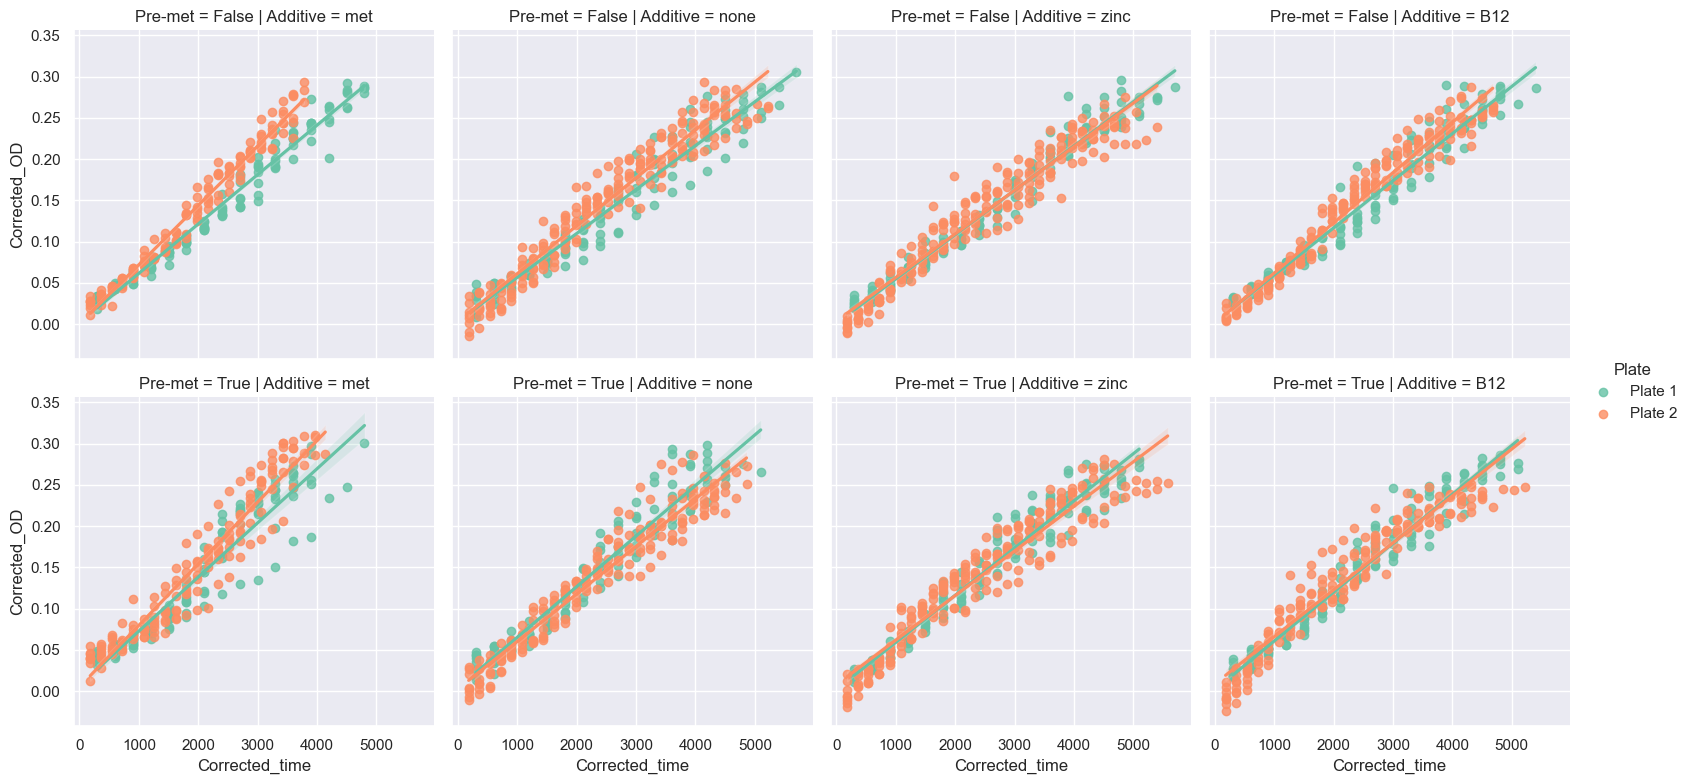

In [322]:
sns.lmplot(x="Corrected_time", y="Corrected_OD", hue="Plate", col="Additive", row="Pre-met", height=4,data=gr_time_filter.to_pandas())

In [324]:
predicted_gr = gr_time_filter.to_pandas().groupby(['Additive', 'Plate']).apply(regress_error, 'Corrected_OD', ['Corrected_time'])
predicted_gr = predicted_gr.reset_index()

predicted_gr

,Additive,Plate,slope,intercept,slope_e,intercept_e
0,B12,Plate 1,0.000058,0.002135,7.882711e-07,0.002277
1,B12,Plate 2,0.000059,0.004906,7.602954e-07,0.001999
2,met,Plate 1,0.000061,0.006587,1.198264e-06,0.003115
3,met,Plate 2,0.000073,0.002657,1.077934e-06,0.002362
4,none,Plate 1,0.000056,0.006395,1.061065e-06,0.003044
5,none,Plate 2,0.000058,0.002852,7.410623e-07,0.002023
6,zinc,Plate 1,0.000055,0.002147,7.214330e-07,0.002166
7,zinc,Plate 2,0.000053,0.005848,7.657910e-07,0.002141


# Plate two

In [298]:
df = pl.read_csv("growth_data/cyrus_012624.csv")
df = df.drop('T600')
df

Time,A3,A4,A5,A6,A7,A8,A9,A10,B3,B4,B5,B6,B7,B8,B9,B10,C3,C4,C5,C6,C7,C8,C9,C10,D3,D4,D5,D6,D7,D8,D9,D10,E3,E4,E5,E6,E7,E8,E9,E10,F3,F4,F5,F6,F7,F8,F9,F10,G3,G4,G5,G6,G7,G8,G9,G10,H3,H4,H5,H6,H7,H8,H9,H10
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""00:02:10""",0.232,0.277,0.25,0.26,0.189,0.2,0.237,0.207,0.109,0.199,0.227,0.268,0.22,0.198,0.206,0.206,0.197,0.277,0.223,0.176,0.19,0.312,0.233,0.254,0.233,0.252,0.142,0.24,0.287,0.223,0.261,0.172,0.176,0.196,0.243,0.18,0.248,0.21,0.22,0.127,0.208,0.228,0.153,0.173,0.241,0.228,0.263,0.238,0.215,0.246,0.243,0.127,0.207,0.27,0.263,0.263,0.213,0.268,0.199,0.2,0.11,0.219,0.195,0.211
"""00:05:10""",0.225,0.267,0.237,0.239,0.156,0.192,0.226,0.2,0.109,0.198,0.223,0.261,0.209,0.181,0.196,0.198,0.194,0.274,0.222,0.173,0.188,0.305,0.228,0.249,0.23,0.25,0.137,0.237,0.286,0.218,0.258,0.17,0.175,0.195,0.242,0.177,0.248,0.206,0.214,0.123,0.205,0.227,0.144,0.163,0.235,0.225,0.259,0.23,0.213,0.245,0.241,0.123,0.205,0.265,0.25,0.255,0.211,0.265,0.196,0.197,0.11,0.218,0.194,0.21
"""00:08:10""",0.225,0.265,0.237,0.242,0.159,0.197,0.229,0.199,0.111,0.199,0.221,0.256,0.202,0.175,0.191,0.197,0.193,0.274,0.221,0.17,0.185,0.304,0.223,0.246,0.228,0.248,0.136,0.236,0.284,0.215,0.256,0.168,0.174,0.195,0.242,0.178,0.247,0.205,0.209,0.121,0.204,0.222,0.143,0.158,0.233,0.225,0.256,0.226,0.212,0.246,0.243,0.122,0.205,0.263,0.242,0.25,0.212,0.265,0.194,0.195,0.109,0.218,0.195,0.209
"""00:11:10""",0.224,0.264,0.237,0.245,0.161,0.197,0.229,0.199,0.111,0.197,0.221,0.254,0.2,0.173,0.19,0.196,0.193,0.273,0.22,0.169,0.186,0.296,0.22,0.245,0.227,0.246,0.137,0.234,0.284,0.214,0.254,0.168,0.175,0.195,0.243,0.178,0.246,0.203,0.207,0.121,0.203,0.218,0.143,0.157,0.233,0.228,0.254,0.224,0.212,0.245,0.243,0.121,0.203,0.26,0.241,0.249,0.212,0.265,0.192,0.195,0.117,0.218,0.194,0.209
"""00:14:10""",0.224,0.264,0.236,0.248,0.165,0.197,0.23,0.198,0.113,0.196,0.221,0.255,0.199,0.172,0.19,0.196,0.193,0.273,0.22,0.168,0.186,0.293,0.219,0.244,0.227,0.245,0.139,0.233,0.283,0.214,0.254,0.168,0.175,0.194,0.243,0.178,0.246,0.203,0.206,0.121,0.203,0.218,0.143,0.159,0.234,0.233,0.253,0.223,0.211,0.245,0.242,0.121,0.201,0.259,0.241,0.248,0.212,0.265,0.191,0.194,0.112,0.219,0.194,0.209
"""00:17:10""",0.224,0.264,0.236,0.248,0.169,0.198,0.232,0.199,0.113,0.197,0.222,0.258,0.199,0.171,0.189,0.195,0.194,0.274,0.22,0.168,0.187,0.294,0.219,0.244,0.227,0.245,0.14,0.233,0.283,0.214,0.256,0.168,0.176,0.194,0.242,0.179,0.246,0.203,0.205,0.122,0.203,0.215,0.142,0.161,0.237,0.235,0.253,0.224,0.21,0.245,0.243,0.121,0.201,0.261,0.244,0.249,0.212,0.266,0.19,0.193,0.11,0.219,0.196,0.209
"""00:20:10""",0.224,0.264,0.236,0.25,0.172,0.2,0.232,0.199,0.113,0.197,0.222,0.255,0.199,0.171,0.19,0.197,0.194,0.275,0.22,0.168,0.186,0.292,0.219,0.243,0.228,0.245,0.14,0.232,0.283,0.214,0.257,0.168,0.175,0.195,0.242,0.178,0.246,0.204,0.204,0.123,0.203,0.216,0.142,0.161,0.238,0.237,0.254,0.224,0.21,0.246,0.243,0.122,0.202,0.262,0.245,0.25,0.212,0.266,0.189,0.193,0.111,0.22,0.196,0.21
"""00:23:10""",0.224,0.264,0.238,0.251,0.176,0.202,0.233,0.201,0.115,0.197,0.222,0.257,0.199,0.171,0.192,0.197,0.194,0.275,0.22,0.168,0.189,0.293,0.22,0.244,0.228,0.247,0.141,0.232,0.283,0.215,0.258,0.169,0.175,0.195,0.242,0.179,0.245,0.204,0.204,0.123,0.203,0.214,0.143,0.163,0.239,0.238,0.254,0.225,0.21,0.247,0.244,0.123,0.203,0.264,0.249,0.251,0.212,0.266,0.189,0.193,0.119,0.22,0.195,0.21
"""00:26:10""",0.225,0.265,0.239,0.253,0.183,0.205,0.235,0.202,0.116,0.197,0.222,0.257,0.199,0.172,0.193,0.198,0.194,0.276,0.221,0.17,0.19,0.297,0.221,0.244,0.229,0.247,0.143,0.235,0.284,0.216,0.26,0.17,0.176,0.195,0.242,0.179,0.245,0.204,0.203,0.125,0.203,0.215,0.145,0.164,0.24,0.24,0.256,0.228,0.209,0.247,0.245,0.125,0.205,0.267,0.251,0.259,0.212,0.267,0.188,0.193,0.117,0.221,0.196,0.21


In [299]:
bf = pl.read_csv("growth_data/cyrus_012624_blanks.csv")
bf = bf.drop('T600')
bfm = bf.mean()
bfm[0, "Time"] = 0
bfm = bfm.with_columns(bfm["Time"].cast(pl.Int64))

In [300]:
df = pl.read_csv("growth_data/cyrus_012624.csv")
df = df.drop('T600')
df

# time conversion
df = df.with_columns(pl.col("Time").str.to_time("%H:%M:%S"))
df = df.with_columns(3600 * df['Time'].dt.hour().cast(pl.Int64) + 60 * df['Time'].dt.minute().cast(pl.Int64) + df['Time'].dt.second())

# zero by first measurement
df = df.with_columns([pl.col(c) - df[0, c] for c in df.columns])

# melt to experiments
df = df.melt(id_vars="Time", variable_name="Well", value_name="OD")
df = df.with_columns((df["Well"].str.slice(0,1)).alias("Experiment"))
df = df.with_columns((df["Well"].str.slice(1)).alias("Replicate"))
df

df

Time,Well,OD,Experiment,Replicate
i64,str,f64,str,str
0,"""A3""",0.0,"""A""","""3"""
180,"""A3""",-0.007,"""A""","""3"""
360,"""A3""",-0.007,"""A""","""3"""
540,"""A3""",-0.008,"""A""","""3"""
720,"""A3""",-0.008,"""A""","""3"""
900,"""A3""",-0.008,"""A""","""3"""
1080,"""A3""",-0.008,"""A""","""3"""
1260,"""A3""",-0.008,"""A""","""3"""
1440,"""A3""",-0.007,"""A""","""3"""


In [301]:
# join with experiment type
column_names = ["Experiment", "Abb", "Description", "Pre-met", "Additive"]
conversion = [["A", "Rrm", "Rich + met, ++met", True, "met"], 
              ["B", "Rr", "Rich - met, ++met", True, "none"], 
              ["C", "RrZ", "Rich - met + Zn, ++met", True, "zinc"], 
              ["D", "Rrb", "Rich - met + B12, ++met", True, "B12"],
              ["E", "rm", "Rich + met, --met", False, "met"],
              ["F", "r", "Rich - met, --met", False, "none"],
              ["G", "rz", "Rich - met, --met", False, "zinc"],
              ["H", "rb", "Rich - met, --met", False, "B12"]]

exp = pl.DataFrame(conversion)
exp.columns = column_names

exp

Experiment,Abb,Description,Pre-met,Additive
str,str,str,bool,str
"""A""","""Rrm""","""Rich + met, ++…",true,"""met"""
"""B""","""Rr""","""Rich - met, ++…",true,"""none"""
"""C""","""RrZ""","""Rich - met + Z…",true,"""zinc"""
"""D""","""Rrb""","""Rich - met + B…",true,"""B12"""
"""E""","""rm""","""Rich + met, --…",false,"""met"""
"""F""","""r""","""Rich - met, --…",false,"""none"""
"""G""","""rz""","""Rich - met, --…",false,"""zinc"""
"""H""","""rb""","""Rich - met, --…",false,"""B12"""


In [302]:
mdf = df.join(exp, on="Experiment")

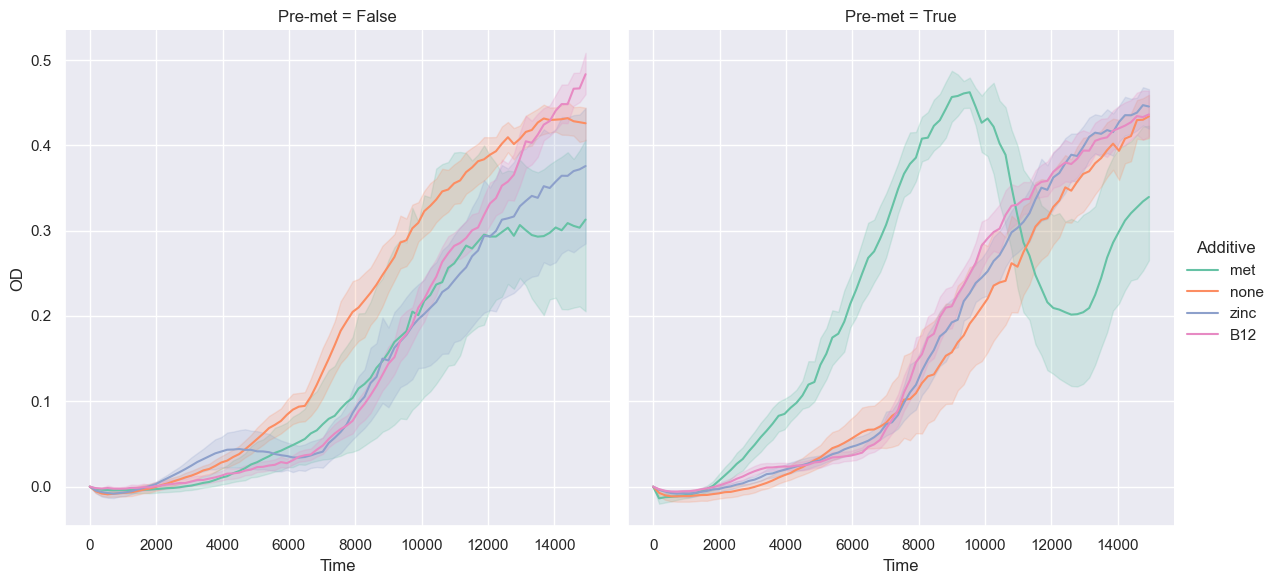

In [303]:
sns.relplot(x="Time", y="OD", kind="line",  hue="Additive", col="Pre-met", height=6, col_wrap=2, data=mdf.filter(pl.col("Time")<15000))

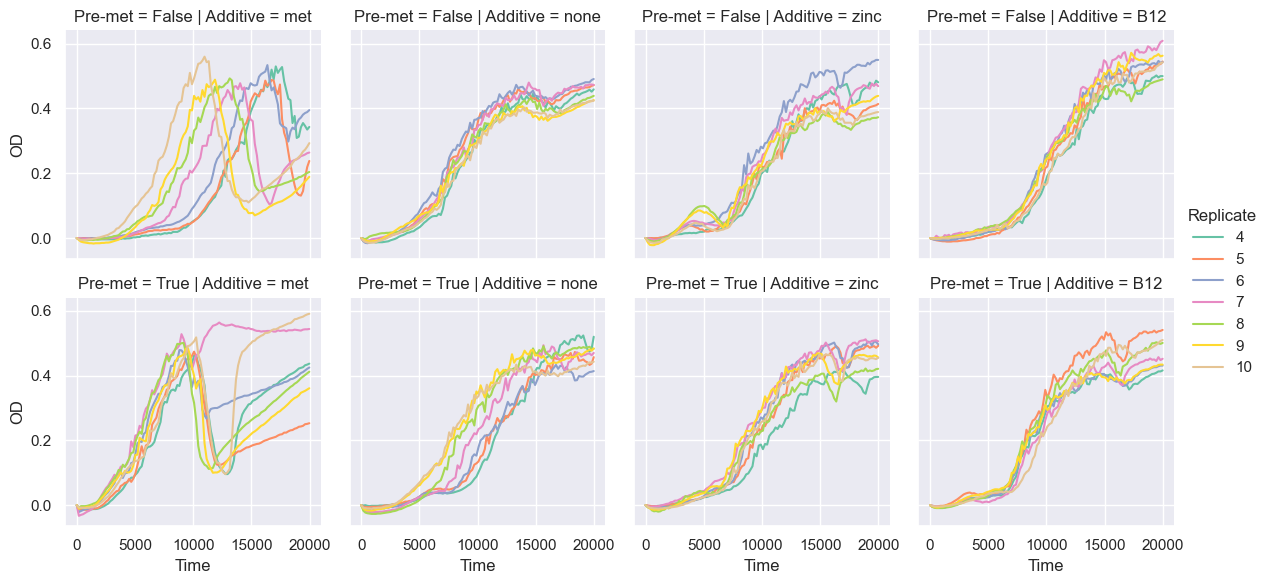

In [304]:
sns.relplot(x="Time", y="OD", hue="Replicate", kind="line", row="Pre-met", col="Additive", height=3, \
            data=mdf.filter(
                (pl.col("Time")<20000) & 
                (pl.col("Replicate") != "3")
           ))

In [305]:
growth_rate_precise = data=mdf.filter(
                (pl.col("Time")<20000) 
           )


minimum_start_times = growth_rate_precise.filter(pl.col("OD") <= 0.06).group_by("Well").agg(pl.max("Time").alias("Time_exp_start")).sort("Time_exp_start")
minimum_end_times = growth_rate_precise.filter(pl.col("OD") >= 0.30).group_by("Well").agg(pl.min("Time").alias("Time_exp_end")).sort("Time_exp_end")

growth_rate_precise = growth_rate_precise.join(minimum_start_times, on="Well")
growth_rate_precise = growth_rate_precise.join(minimum_end_times, on="Well")
gr_time_filter = growth_rate_precise.filter((pl.col("Time") > pl.col("Time_exp_start")) & (pl.col("Time") < pl.col("Time_exp_end")))
gr_time_filter = gr_time_filter.with_columns((pl.col("Time") - pl.col("Time_exp_start")).alias("Corrected_time"))

# correct all od values to start at 0
# start_od = gr_time_filter.group_by("Well").agg(pl.min("OD").alias("Start_OD")).sort("Start_OD")
# gr_time_filter = gr_time_filter.join(start_od, on="Well")
# gr_time_filter = gr_time_filter.with_columns((pl.col("OD") - pl.col("Start_OD")).alias("Corrected_OD"))

# correct by linear fit

#This is what you need
correction_offset = gr_time_filter.to_pandas().groupby('Well').apply(regress, 'OD', ['Corrected_time'])
correction_offset = correction_offset.reset_index()
correction_offset = pl.DataFrame(correction_offset)

gr_time_filter = gr_time_filter.join(correction_offset, on="Well")
gr_time_filter = gr_time_filter.with_columns((pl.col("OD") - pl.col("intercept")).alias("Corrected_OD"))

gr_time_filter

Time,Well,OD,Experiment,Replicate,Abb,Description,Pre-met,Additive,Time_exp_start,Time_exp_end,Corrected_time,Corrected_time_right,intercept,Corrected_OD
i64,str,f64,str,str,str,str,bool,str,i64,i64,i64,f64,f64,f64
4140,"""A3""",0.066,"""A""","""3""","""Rrm""","""Rich + met, ++…",true,"""met""",3960,7560,180,0.000069,0.032632,0.033368
4320,"""A3""",0.075,"""A""","""3""","""Rrm""","""Rich + met, ++…",true,"""met""",3960,7560,360,0.000069,0.032632,0.042368
4500,"""A3""",0.085,"""A""","""3""","""Rrm""","""Rich + met, ++…",true,"""met""",3960,7560,540,0.000069,0.032632,0.052368
4680,"""A3""",0.082,"""A""","""3""","""Rrm""","""Rich + met, ++…",true,"""met""",3960,7560,720,0.000069,0.032632,0.049368
4860,"""A3""",0.087,"""A""","""3""","""Rrm""","""Rich + met, ++…",true,"""met""",3960,7560,900,0.000069,0.032632,0.054368
5040,"""A3""",0.09,"""A""","""3""","""Rrm""","""Rich + met, ++…",true,"""met""",3960,7560,1080,0.000069,0.032632,0.057368
5220,"""A3""",0.105,"""A""","""3""","""Rrm""","""Rich + met, ++…",true,"""met""",3960,7560,1260,0.000069,0.032632,0.072368
5400,"""A3""",0.115,"""A""","""3""","""Rrm""","""Rich + met, ++…",true,"""met""",3960,7560,1440,0.000069,0.032632,0.082368
5580,"""A3""",0.129,"""A""","""3""","""Rrm""","""Rich + met, ++…",true,"""met""",3960,7560,1620,0.000069,0.032632,0.096368


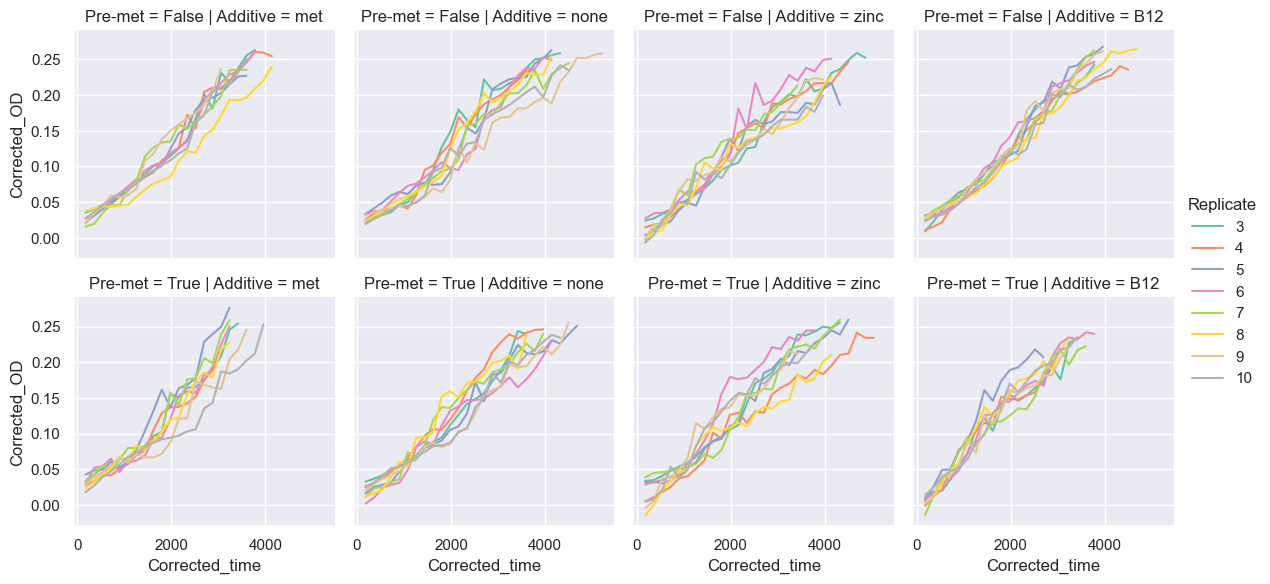

In [306]:
sns.relplot(x="Corrected_time", y="Corrected_OD", hue="Replicate", kind="line", row="Pre-met", col="Additive", height=3, \
            data=gr_time_filter)

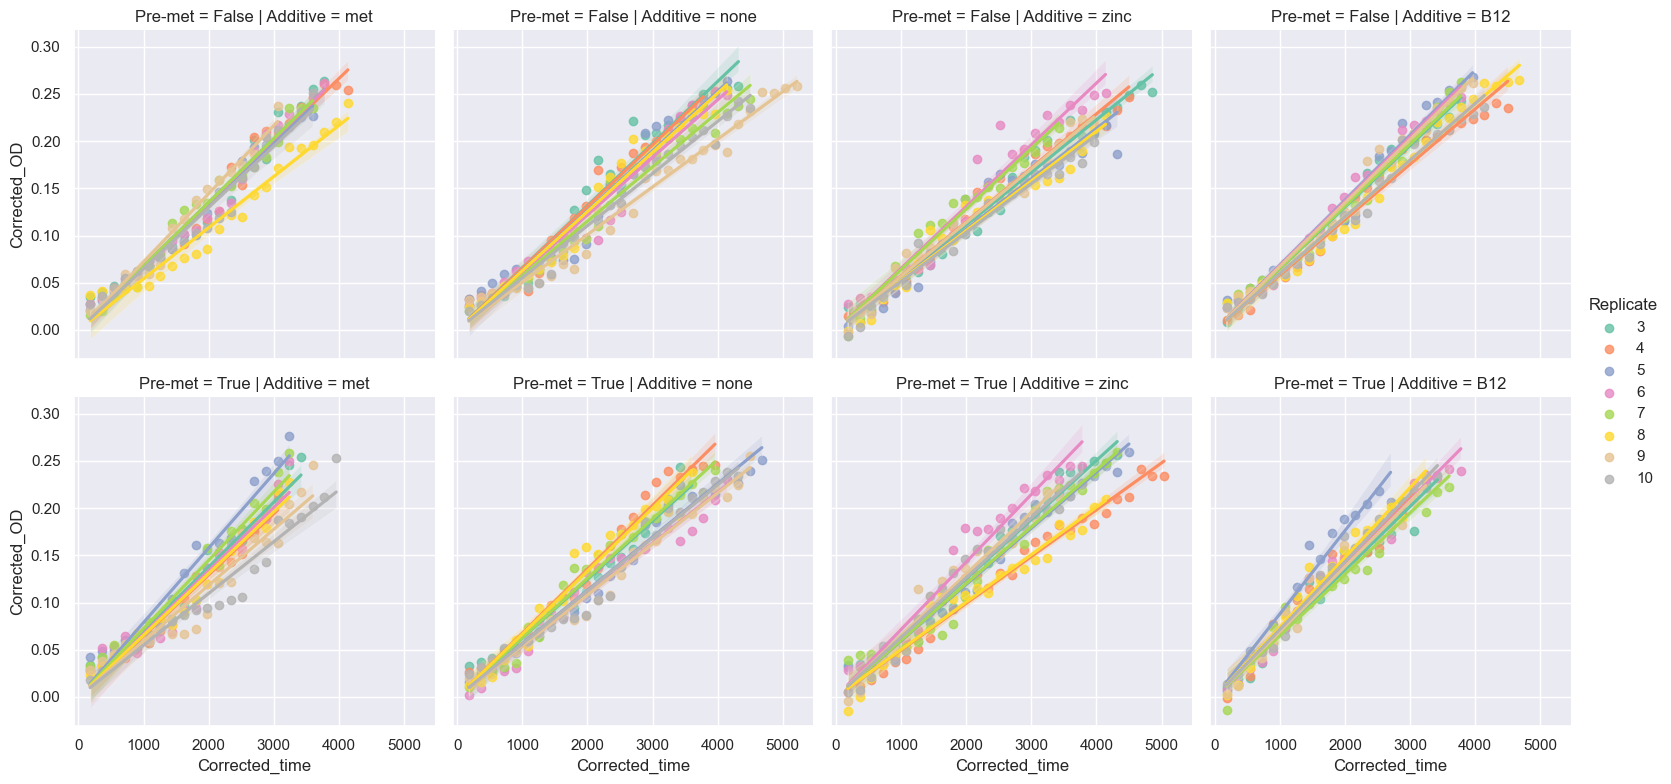

In [307]:
sns.lmplot(x="Corrected_time", y="Corrected_OD", hue="Replicate", col="Additive", row="Pre-met", height=4,data=gr_time_filter.to_pandas())

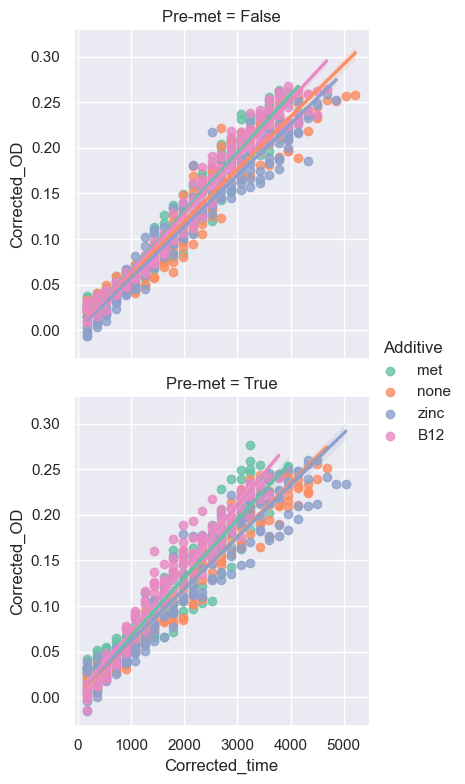

In [308]:
sns.lmplot(x="Corrected_time", y="Corrected_OD", hue="Additive", row="Pre-met", height=4,data=gr_time_filter.to_pandas())

In [309]:
predicted_gr = gr_time_filter.to_pandas().groupby('Additive').apply(regress_error, 'Corrected_OD', ['Corrected_time'])
predicted_gr = predicted_gr.reset_index()

predicted_gr

,Additive,slope,intercept,slope_e,intercept_e
0,B12,0.000064,0.005133,8.400059e-07,0.001903
1,met,0.000064,0.002766,1.026165e-06,0.002208
2,none,0.000058,0.003657,7.807927e-07,0.001988
3,zinc,0.000057,0.003028,8.443688e-07,0.002128


# 2nd round, different overnight media +/- met

In [2]:
bf = pl.read_csv("growth_data/adrian_growth_jan25_blanks.csv")
bf = bf.drop('T� 600')
bfm = bf.mean()
bfm[0, "Time"] = 0
bfm = bfm.with_columns(bfm["Time"].cast(pl.Int64))

In [3]:
df = pl.read_csv("growth_data/adrian_growth_jan25_v2.csv")
df = df.drop('T∞ 600')
df

Time,A2,A3,A4,A5,A6,A7,A8,A9,B2,B3,B4,B5,B6,B7,B8,B9,C2,C3,C4,C5,C6,C7,C8,C9,D2,D3,D4,D5,D6,D7,D8,D9,E2,E3,E4,E5,E6,E7,E8,E9,F2,F3,F4,F5,F6,F7,F8,F9,G2,G3,G4,G5,G6,G7,G8,G9,H2,H3,H4,H5,H6,H7,H8,H9
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""00:04:10""",0.924,0.844,0.944,0.963,1.081,0.823,0.942,1.072,0.928,0.939,1.04,0.863,0.742,0.71,0.998,0.749,0.916,0.917,0.81,0.801,0.842,0.968,0.85,1.086,0.836,0.896,0.934,0.848,0.966,1.031,1.074,0.894,0.859,0.81,0.927,1.08,0.833,0.924,0.873,0.783,0.641,0.742,0.962,0.663,0.772,0.93,0.882,0.894,0.834,0.818,0.704,0.911,0.743,0.864,0.841,0.774,0.951,0.848,0.932,0.916,0.786,0.768,0.883,0.938
"""00:09:10""",0.923,0.842,0.944,0.964,1.08,0.823,0.943,1.067,0.93,0.942,1.041,0.862,0.737,0.71,0.998,0.748,0.917,0.916,0.812,0.797,0.837,0.97,0.85,1.087,0.837,0.896,0.932,0.851,0.965,1.028,1.074,0.893,0.858,0.808,0.928,1.079,0.836,0.926,0.875,0.782,0.645,0.738,0.96,0.664,0.772,0.93,0.882,0.894,0.843,0.819,0.704,0.911,0.744,0.863,0.841,0.77,0.947,0.847,0.931,0.914,0.784,0.768,0.881,0.936
"""00:14:10""",0.924,0.842,0.941,0.962,1.079,0.829,0.945,1.065,0.932,0.946,1.042,0.86,0.737,0.712,0.999,0.747,0.917,0.919,0.811,0.793,0.838,0.966,0.85,1.087,0.835,0.897,0.93,0.852,0.963,1.025,1.076,0.894,0.858,0.808,0.928,1.077,0.834,0.929,0.878,0.783,0.646,0.736,0.959,0.663,0.771,0.929,0.881,0.892,0.843,0.823,0.703,0.909,0.743,0.864,0.842,0.767,0.938,0.847,0.931,0.914,0.786,0.768,0.882,0.935
"""00:19:10""",0.925,0.84,0.941,0.962,1.082,0.831,0.946,1.065,0.93,0.951,1.042,0.859,0.739,0.713,0.998,0.747,0.917,0.92,0.812,0.791,0.832,0.967,0.85,1.087,0.836,0.899,0.928,0.852,0.961,1.025,1.076,0.894,0.858,0.808,0.927,1.078,0.832,0.932,0.877,0.782,0.65,0.736,0.959,0.667,0.77,0.929,0.881,0.892,0.845,0.821,0.703,0.91,0.742,0.862,0.842,0.767,0.937,0.847,0.931,0.915,0.785,0.768,0.882,0.934
"""00:24:10""",0.924,0.841,0.942,0.961,1.083,0.845,0.946,1.064,0.932,0.953,1.042,0.859,0.747,0.716,0.999,0.747,0.918,0.919,0.811,0.792,0.833,0.968,0.848,1.087,0.836,0.9,0.928,0.854,0.96,1.026,1.075,0.894,0.858,0.808,0.926,1.076,0.832,0.935,0.879,0.784,0.652,0.735,0.957,0.669,0.771,0.928,0.881,0.89,0.846,0.822,0.704,0.909,0.743,0.861,0.841,0.768,0.936,0.847,0.931,0.915,0.786,0.768,0.883,0.936
"""00:29:10""",0.923,0.838,0.942,0.96,1.082,0.851,0.95,1.064,0.93,0.955,1.041,0.857,0.75,0.718,0.998,0.747,0.916,0.924,0.81,0.791,0.826,0.97,0.848,1.086,0.835,0.902,0.927,0.855,0.96,1.026,1.076,0.895,0.857,0.809,0.926,1.074,0.832,0.937,0.88,0.785,0.656,0.735,0.957,0.67,0.77,0.927,0.882,0.89,0.847,0.822,0.704,0.909,0.742,0.861,0.841,0.772,0.937,0.846,0.931,0.915,0.786,0.768,0.884,0.937
"""00:34:10""",0.923,0.842,0.942,0.96,1.082,0.862,0.947,1.064,0.931,0.957,1.042,0.859,0.748,0.722,0.999,0.749,0.915,0.923,0.811,0.79,0.823,0.968,0.848,1.085,0.835,0.903,0.926,0.855,0.958,1.026,1.076,0.893,0.858,0.81,0.925,1.073,0.832,0.94,0.88,0.786,0.657,0.734,0.956,0.673,0.771,0.928,0.881,0.889,0.848,0.823,0.705,0.909,0.742,0.859,0.842,0.773,0.932,0.847,0.931,0.916,0.786,0.769,0.883,0.935
"""00:39:10""",0.921,0.841,0.94,0.96,1.081,0.86,0.947,1.064,0.931,0.959,1.041,0.859,0.745,0.72,0.999,0.749,0.915,0.92,0.81,0.791,0.819,0.969,0.846,1.085,0.834,0.905,0.926,0.855,0.958,1.026,1.078,0.893,0.86,0.811,0.925,1.073,0.83,0.942,0.883,0.787,0.661,0.736,0.957,0.676,0.771,0.927,0.882,0.89,0.849,0.823,0.704,0.912,0.745,0.858,0.843,0.775,0.936,0.847,0.932,0.918,0.787,0.769,0.886,0.935
"""00:44:10""",0.919,0.84,0.94,0.959,1.081,0.865,0.948,1.063,0.931,0.959,1.04,0.86,0.746,0.726,1.0,0.751,0.916,0.919,0.809,0.791,0.811,0.969,0.847,1.085,0.834,0.906,0.926,0.854,0.958,1.028,1.078,0.894,0.863,0.811,0.925,1.072,0.829,0.944,0.88,0.789,0.663,0.726,0.956,0.676,0.771,0.927,0.882,0.889,0.849,0.822,0.706,0.908,0.741,0.857,0.843,0.772,0.941,0.847,0.93,0.918,0.787,0.774,0.886,0.938


In [4]:
df = df.with_columns(pl.col("Time").str.to_time("%H:%M:%S"))
df = df.with_columns(3600 * df['Time'].dt.hour().cast(pl.Int64) + 60 * df['Time'].dt.minute().cast(pl.Int64) + df['Time'].dt.second())

df

Time,A2,A3,A4,A5,A6,A7,A8,A9,B2,B3,B4,B5,B6,B7,B8,B9,C2,C3,C4,C5,C6,C7,C8,C9,D2,D3,D4,D5,D6,D7,D8,D9,E2,E3,E4,E5,E6,E7,E8,E9,F2,F3,F4,F5,F6,F7,F8,F9,G2,G3,G4,G5,G6,G7,G8,G9,H2,H3,H4,H5,H6,H7,H8,H9
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
250,0.924,0.844,0.944,0.963,1.081,0.823,0.942,1.072,0.928,0.939,1.04,0.863,0.742,0.71,0.998,0.749,0.916,0.917,0.81,0.801,0.842,0.968,0.85,1.086,0.836,0.896,0.934,0.848,0.966,1.031,1.074,0.894,0.859,0.81,0.927,1.08,0.833,0.924,0.873,0.783,0.641,0.742,0.962,0.663,0.772,0.93,0.882,0.894,0.834,0.818,0.704,0.911,0.743,0.864,0.841,0.774,0.951,0.848,0.932,0.916,0.786,0.768,0.883,0.938
550,0.923,0.842,0.944,0.964,1.08,0.823,0.943,1.067,0.93,0.942,1.041,0.862,0.737,0.71,0.998,0.748,0.917,0.916,0.812,0.797,0.837,0.97,0.85,1.087,0.837,0.896,0.932,0.851,0.965,1.028,1.074,0.893,0.858,0.808,0.928,1.079,0.836,0.926,0.875,0.782,0.645,0.738,0.96,0.664,0.772,0.93,0.882,0.894,0.843,0.819,0.704,0.911,0.744,0.863,0.841,0.77,0.947,0.847,0.931,0.914,0.784,0.768,0.881,0.936
850,0.924,0.842,0.941,0.962,1.079,0.829,0.945,1.065,0.932,0.946,1.042,0.86,0.737,0.712,0.999,0.747,0.917,0.919,0.811,0.793,0.838,0.966,0.85,1.087,0.835,0.897,0.93,0.852,0.963,1.025,1.076,0.894,0.858,0.808,0.928,1.077,0.834,0.929,0.878,0.783,0.646,0.736,0.959,0.663,0.771,0.929,0.881,0.892,0.843,0.823,0.703,0.909,0.743,0.864,0.842,0.767,0.938,0.847,0.931,0.914,0.786,0.768,0.882,0.935
1150,0.925,0.84,0.941,0.962,1.082,0.831,0.946,1.065,0.93,0.951,1.042,0.859,0.739,0.713,0.998,0.747,0.917,0.92,0.812,0.791,0.832,0.967,0.85,1.087,0.836,0.899,0.928,0.852,0.961,1.025,1.076,0.894,0.858,0.808,0.927,1.078,0.832,0.932,0.877,0.782,0.65,0.736,0.959,0.667,0.77,0.929,0.881,0.892,0.845,0.821,0.703,0.91,0.742,0.862,0.842,0.767,0.937,0.847,0.931,0.915,0.785,0.768,0.882,0.934
1450,0.924,0.841,0.942,0.961,1.083,0.845,0.946,1.064,0.932,0.953,1.042,0.859,0.747,0.716,0.999,0.747,0.918,0.919,0.811,0.792,0.833,0.968,0.848,1.087,0.836,0.9,0.928,0.854,0.96,1.026,1.075,0.894,0.858,0.808,0.926,1.076,0.832,0.935,0.879,0.784,0.652,0.735,0.957,0.669,0.771,0.928,0.881,0.89,0.846,0.822,0.704,0.909,0.743,0.861,0.841,0.768,0.936,0.847,0.931,0.915,0.786,0.768,0.883,0.936
1750,0.923,0.838,0.942,0.96,1.082,0.851,0.95,1.064,0.93,0.955,1.041,0.857,0.75,0.718,0.998,0.747,0.916,0.924,0.81,0.791,0.826,0.97,0.848,1.086,0.835,0.902,0.927,0.855,0.96,1.026,1.076,0.895,0.857,0.809,0.926,1.074,0.832,0.937,0.88,0.785,0.656,0.735,0.957,0.67,0.77,0.927,0.882,0.89,0.847,0.822,0.704,0.909,0.742,0.861,0.841,0.772,0.937,0.846,0.931,0.915,0.786,0.768,0.884,0.937
2050,0.923,0.842,0.942,0.96,1.082,0.862,0.947,1.064,0.931,0.957,1.042,0.859,0.748,0.722,0.999,0.749,0.915,0.923,0.811,0.79,0.823,0.968,0.848,1.085,0.835,0.903,0.926,0.855,0.958,1.026,1.076,0.893,0.858,0.81,0.925,1.073,0.832,0.94,0.88,0.786,0.657,0.734,0.956,0.673,0.771,0.928,0.881,0.889,0.848,0.823,0.705,0.909,0.742,0.859,0.842,0.773,0.932,0.847,0.931,0.916,0.786,0.769,0.883,0.935
2350,0.921,0.841,0.94,0.96,1.081,0.86,0.947,1.064,0.931,0.959,1.041,0.859,0.745,0.72,0.999,0.749,0.915,0.92,0.81,0.791,0.819,0.969,0.846,1.085,0.834,0.905,0.926,0.855,0.958,1.026,1.078,0.893,0.86,0.811,0.925,1.073,0.83,0.942,0.883,0.787,0.661,0.736,0.957,0.676,0.771,0.927,0.882,0.89,0.849,0.823,0.704,0.912,0.745,0.858,0.843,0.775,0.936,0.847,0.932,0.918,0.787,0.769,0.886,0.935
2650,0.919,0.84,0.94,0.959,1.081,0.865,0.948,1.063,0.931,0.959,1.04,0.86,0.746,0.726,1.0,0.751,0.916,0.919,0.809,0.791,0.811,0.969,0.847,1.085,0.834,0.906,0.926,0.854,0.958,1.028,1.078,0.894,0.863,0.811,0.925,1.072,0.829,0.944,0.88,0.789,0.663,0.726,0.956,0.676,0.771,0.927,0.882,0.889,0.849,0.822,0.706,0.908,0.741,0.857,0.843,0.772,0.941,0.847,0.93,0.918,0.787,0.774,0.886,0.938


In [5]:
df = df.with_columns([pl.col(c) - df[0, c] for c in df.columns])

In [6]:
df = df.melt(id_vars="Time", variable_name="Well", value_name="OD")
df = df.with_columns((df["Well"].str.slice(0,1)).alias("Experiment"))
df = df.with_columns((df["Well"].str.slice(1)).alias("Replicate"))
df

Time,Well,OD,Experiment,Replicate
i64,str,f64,str,str
0,"""A2""",0.0,"""A""","""2"""
300,"""A2""",-0.001,"""A""","""2"""
600,"""A2""",0.0,"""A""","""2"""
900,"""A2""",0.001,"""A""","""2"""
1200,"""A2""",0.0,"""A""","""2"""
1500,"""A2""",-0.001,"""A""","""2"""
1800,"""A2""",-0.001,"""A""","""2"""
2100,"""A2""",-0.003,"""A""","""2"""
2400,"""A2""",-0.005,"""A""","""2"""


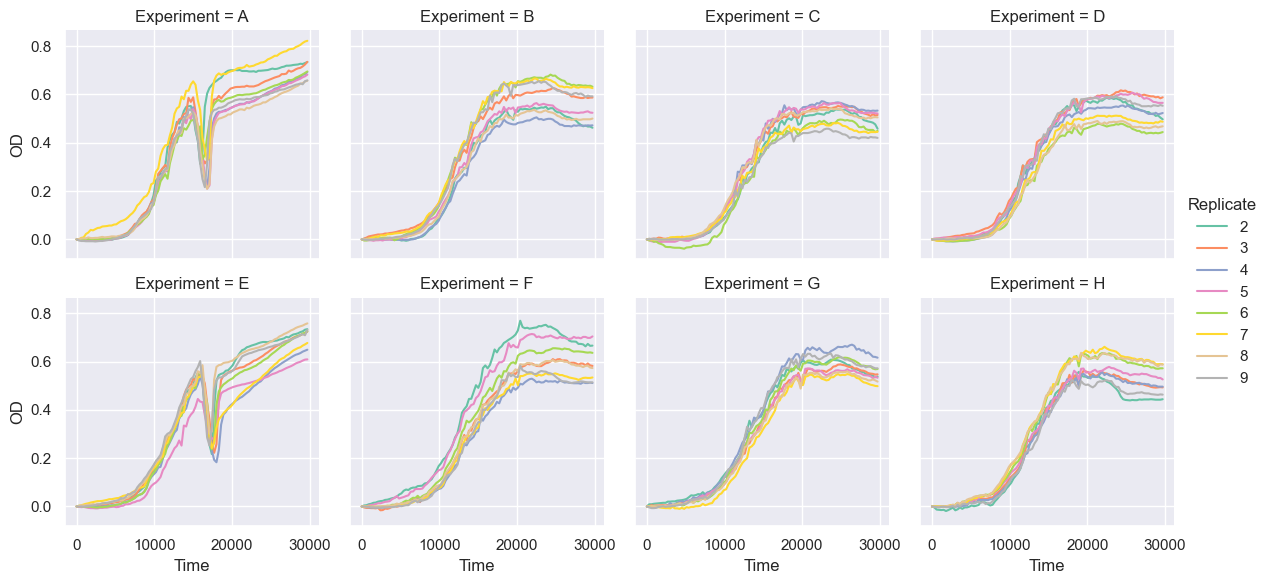

In [7]:
sns.relplot(x="Time", y="OD", hue="Replicate", kind="line", col="Experiment", col_wrap=4, height=3, data=df.filter(pl.col("Time")<30000))

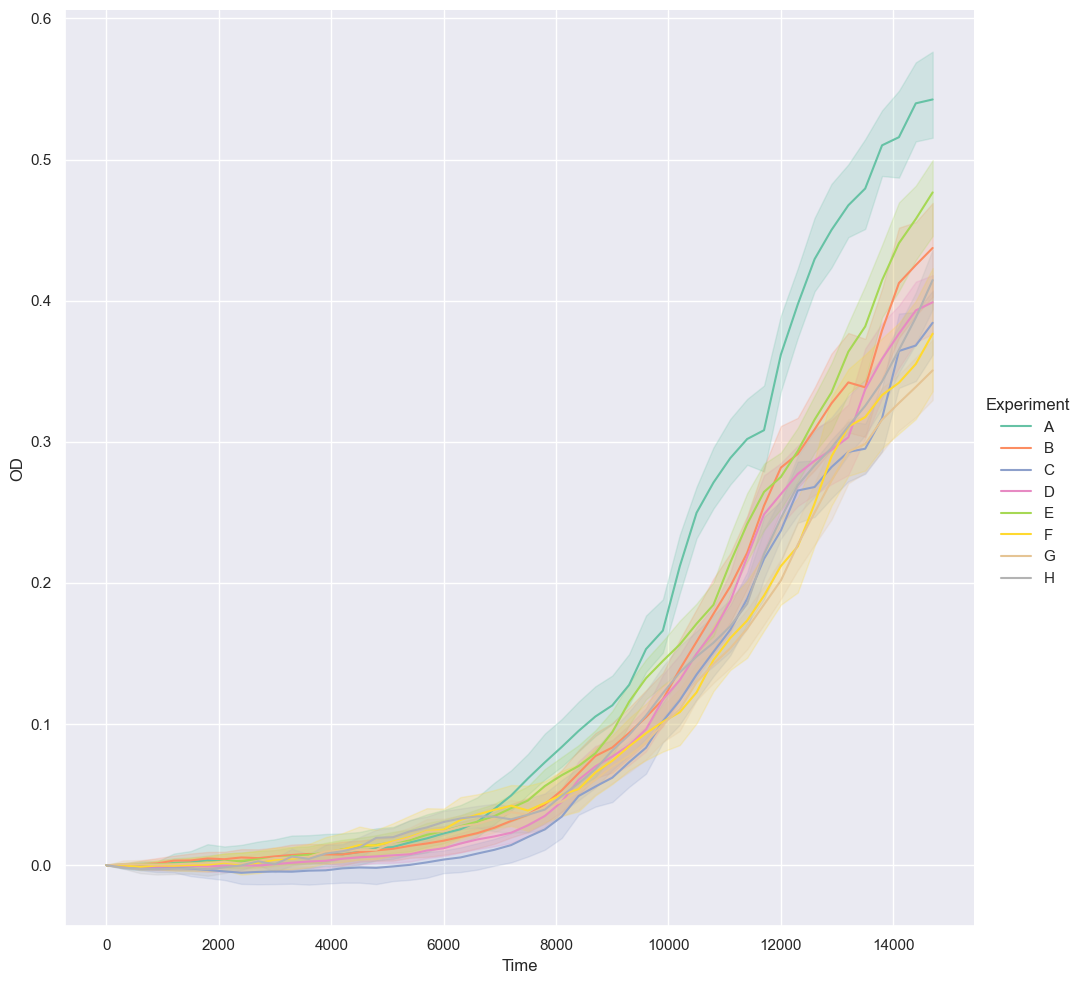

In [8]:
sns.relplot(x="Time", y="OD", hue="Experiment", kind="line", height=10, data=df.filter(pl.col("Time")<15000))

R	First overnight culture in rich + met (otherwise overnight was in media without met)

r	rich

m	met

z	with Zn

z	with B12

In [9]:
column_names = ["Experiment", "Abb", "Description", "Pre-met", "Additive"]
conversion = [["A", "Rrm", "Rich + met, ++met", True, "met"], 
              ["B", "Rr", "Rich - met, ++met", True, "none"], 
              ["C", "RrZ", "Rich - met + Zn, ++met", True, "zinc"], 
              ["D", "Rrb", "Rich - met + B12, ++met", True, "B12"],
              ["E", "rm", "Rich + met, --met", False, "met"],
              ["F", "r", "Rich - met, --met", False, "none"],
              ["G", "rz", "Rich - met, --met", False, "zinc"],
              ["H", "rb", "Rich - met, --met", False, "B12"]]

exp = pl.DataFrame(conversion)
exp.columns = column_names

exp

Experiment,Abb,Description,Pre-met,Additive
str,str,str,bool,str
"""A""","""Rrm""","""Rich + met, ++…",true,"""met"""
"""B""","""Rr""","""Rich - met, ++…",true,"""none"""
"""C""","""RrZ""","""Rich - met + Z…",true,"""zinc"""
"""D""","""Rrb""","""Rich - met + B…",true,"""B12"""
"""E""","""rm""","""Rich + met, --…",false,"""met"""
"""F""","""r""","""Rich - met, --…",false,"""none"""
"""G""","""rz""","""Rich - met, --…",false,"""zinc"""
"""H""","""rb""","""Rich - met, --…",false,"""B12"""


In [10]:
mdf = df.join(exp, on="Experiment")

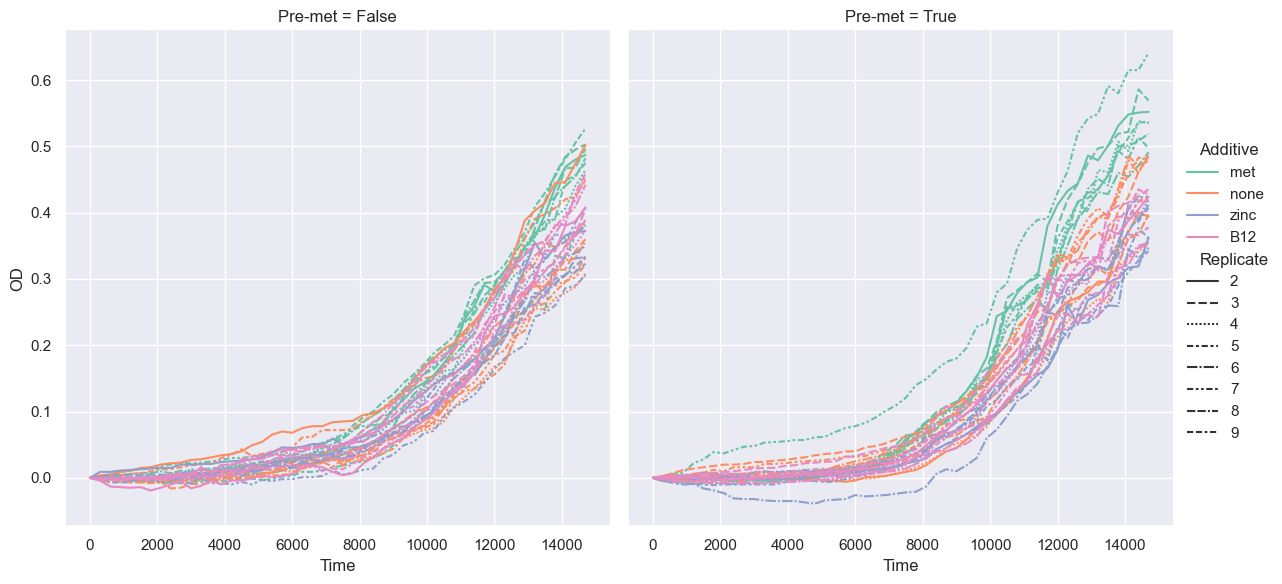

In [11]:
sns.relplot(x="Time", y="OD", kind="line", col="Pre-met", hue="Additive", style="Replicate", height=6, data=mdf.filter(pl.col("Time")<15000))

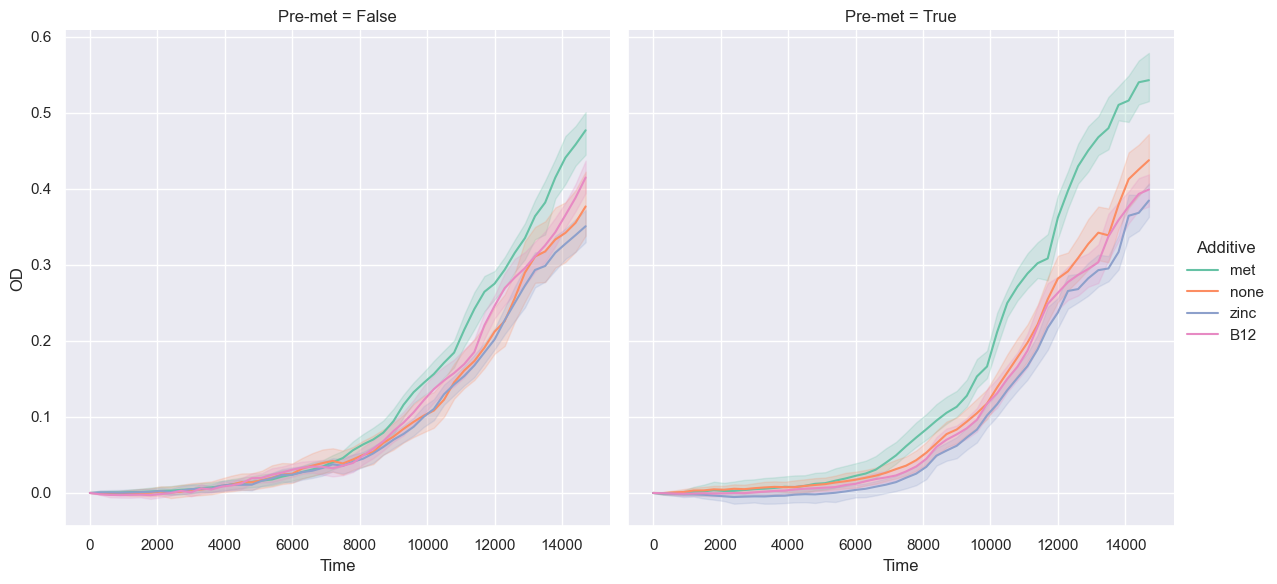

In [12]:
sns.relplot(x="Time", y="OD", kind="line",  hue="Additive", col="Pre-met", height=6, col_wrap=2, data=mdf.filter(pl.col("Time")<15000))

In [15]:
pdf = mdf.filter((pl.col("Time")<15000) & (pl.col("Time") > 10000)).to_pandas()

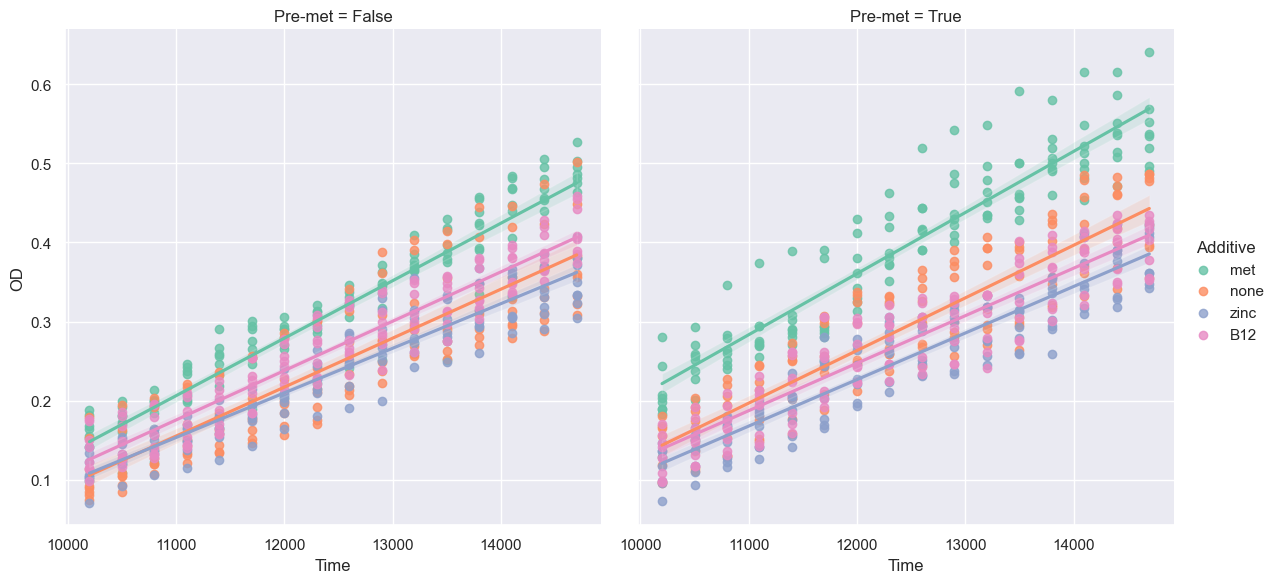

In [16]:
sns.lmplot(x="Time", y="OD", hue="Additive", col="Pre-met", height=6, col_wrap=2, data=pdf)

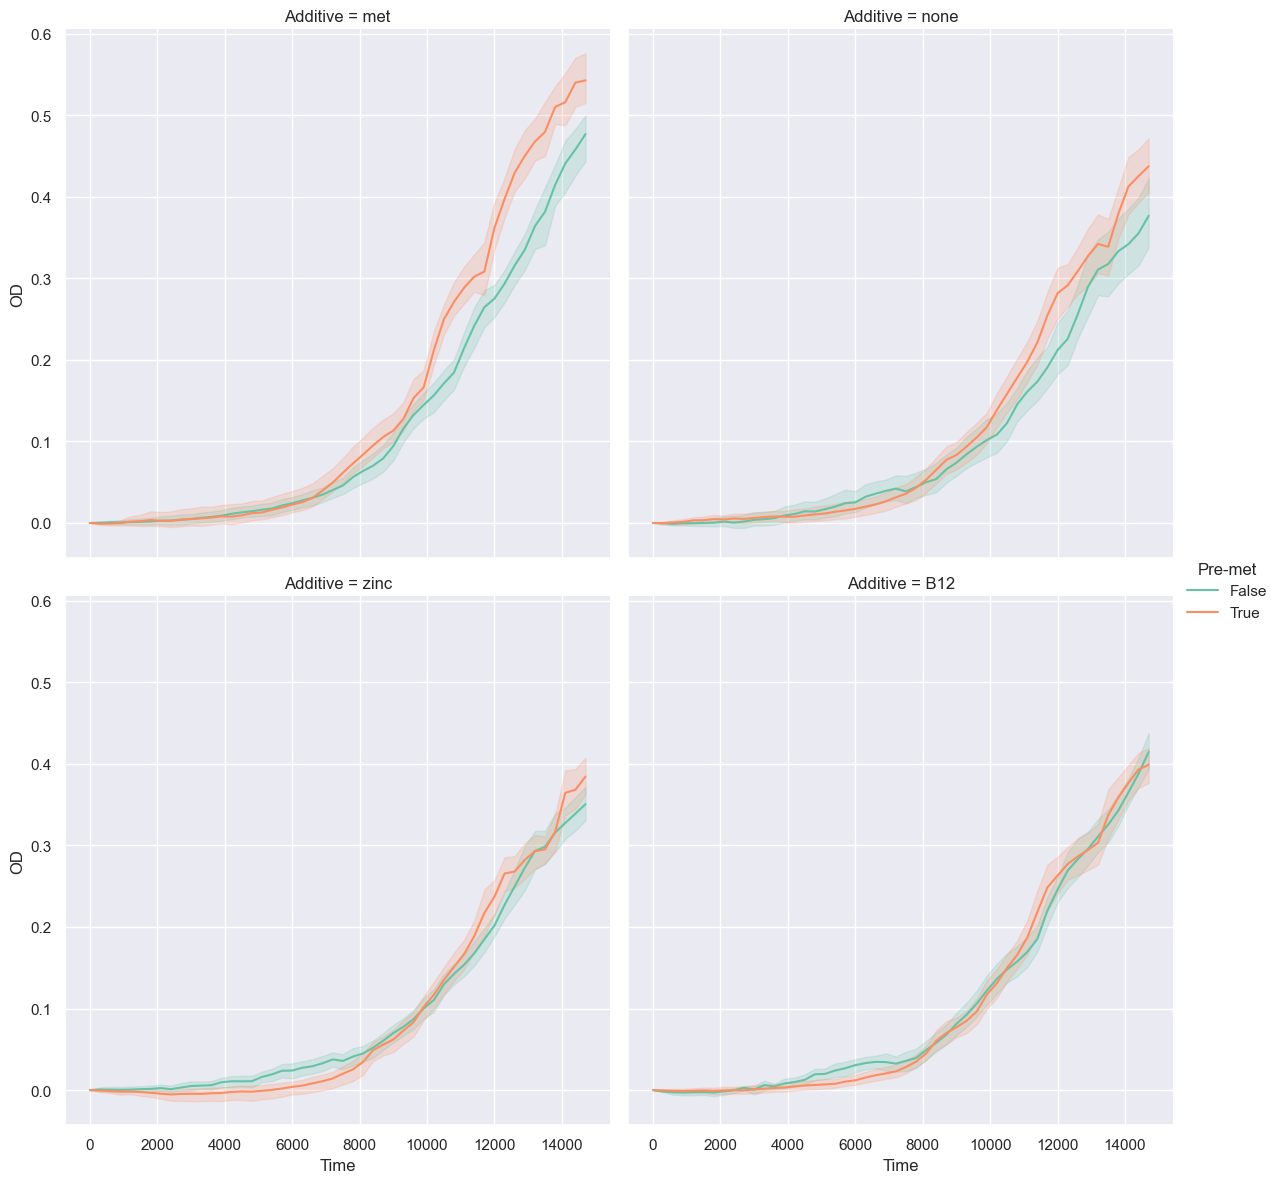

In [41]:
sns.relplot(x="Time", y="OD", kind="line", col="Additive", hue="Pre-met", height=6, col_wrap=2, data=mdf.filter(pl.col("Time")<15000))

In [176]:
meta = pl.read_csv("growth_data/adrian_growth_jan25_indicator.csv")
meta = meta.melt(id_vars='row', variable_name="col", value_name="experiment")
meta = meta.drop_nulls()
meta

row,col,experiment
str,str,str
"""A""","""2""","""Rrm1"""
"""B""","""2""","""Rr1"""
"""C""","""2""","""RrZ1"""
"""D""","""2""","""Rrb1"""
"""E""","""2""","""rm1"""
"""F""","""2""","""r1"""
"""G""","""2""","""rz1"""
"""H""","""2""","""rb1"""
"""A""","""3""","""Rrm2"""


In [214]:
df = pd.read_csv("growth_data/adrian_growth_jan25_v2.csv")
df = df.drop(['T∞ 600'], axis=1)
df["Time"] = pd.to_datetime(df['Time'],format= '%H:%M:%S', coerce=).dt.time

In [218]:
pd.to_datetime(df['Time'],format= '%H:%M:%S').dt.time

0      00:04:10
1      00:09:10
2      00:14:10
3      00:19:10
4      00:24:10
         ...   
212    17:44:10
213    17:49:10
214    17:54:10
215    17:59:10
216    18:04:10
Name: Time, Length: 217, dtype: object

In [189]:
df = pd.read_csv("growth_data/adrian_growth_jan24.csv")
df = df.dropna()
df

,Time,T 600,Series1,Series2,Series3,Series4,Series5,Series6,Time_seconds,mean,ID
0,00:01:02,37.0,0.11,0.11,0.11,0.11,0.11,0.11,62.0,0.010000,RM
1,00:06:02,37.0,0.11,0.11,0.11,0.11,0.11,0.11,362.0,0.010000,RM
2,00:11:02,37.0,0.11,0.11,0.11,0.11,0.11,0.11,662.0,0.010000,RM
3,00:16:02,37.0,0.11,0.11,0.11,0.11,0.11,0.11,962.0,0.010500,RM
4,00:21:02,37.0,0.11,0.11,0.11,0.11,0.11,0.11,1262.0,0.010167,RM
...,...,...,...,...,...,...,...,...,...,...,...
2303,23:41:02,37.0,0.85,0.89,1.03,1.00,0.96,1.07,171662.0,0.869500,RB
2304,23:46:02,37.0,0.85,0.89,1.03,1.00,0.96,1.07,171962.0,0.867833,RB
2305,23:51:02,37.0,0.85,0.90,1.03,1.00,0.96,1.07,172262.0,0.871167,RB
2306,23:56:02,37.0,0.85,0.90,1.03,1.00,0.96,1.07,172562.0,0.870333,RB


In [190]:
df = df.loc[:, ["Series1", "Series2", "Series3", "Series4", "Series5", "Series6", "Time_seconds", "ID"]]

In [191]:
df = df.melt(id_vars=["Time_seconds", "ID"], var_name="Series", value_name="OD")
df = df.rename(columns={"Time_seconds": "Time", "ID": "Experiment"})

for k, v in {"RM": "+met", "RZ": "+Zn", "RB": "+B12", "R": "-met", }.items():
    df["Experiment"] = df["Experiment"].str.replace(k, v)

df

,Time,Experiment,Series,OD
0,62.0,+met,Series1,0.11
1,362.0,+met,Series1,0.11
2,662.0,+met,Series1,0.11
3,962.0,+met,Series1,0.11
4,1262.0,+met,Series1,0.11
...,...,...,...,...
13843,171662.0,+B12,Series6,1.07
13844,171962.0,+B12,Series6,1.07
13845,172262.0,+B12,Series6,1.07
13846,172562.0,+B12,Series6,1.07


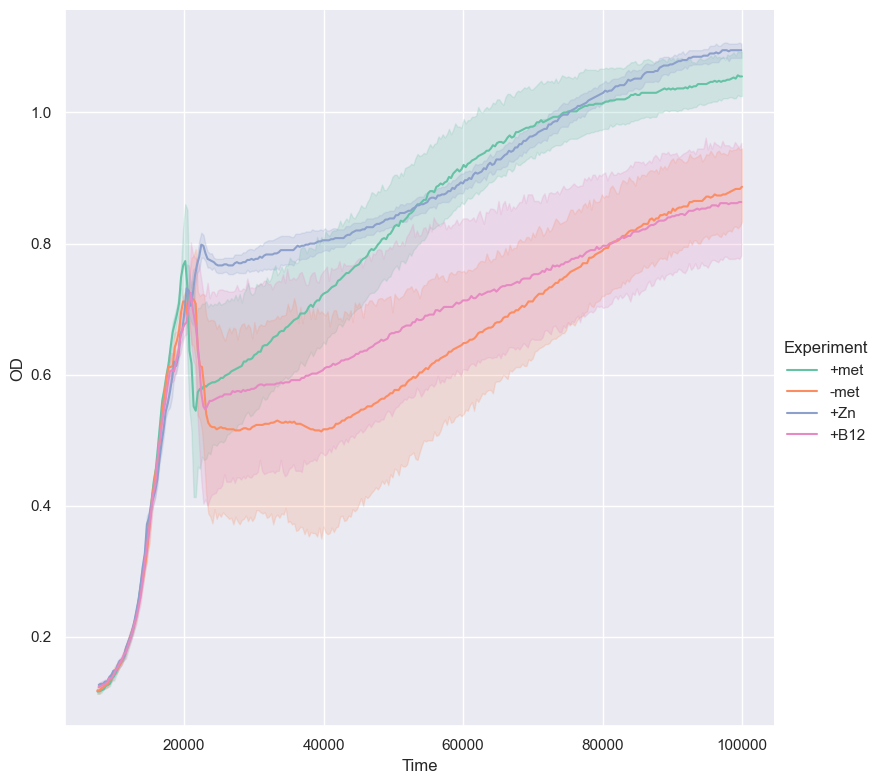

In [192]:
df_truncated = df.copy()

df_truncated.loc[df_truncated["Experiment"].isin(["+B12", "+Zn"]), "Time"] = \
df_truncated.loc[df_truncated["Experiment"].isin(["+B12", "+Zn"]), "Time"] +1100


df_truncated = df_truncated.loc[df_truncated["Time"].between(7500, 100000), :]


sns.relplot(x="Time", y="OD", hue="Experiment", kind="line", data=df_truncated, height=8)

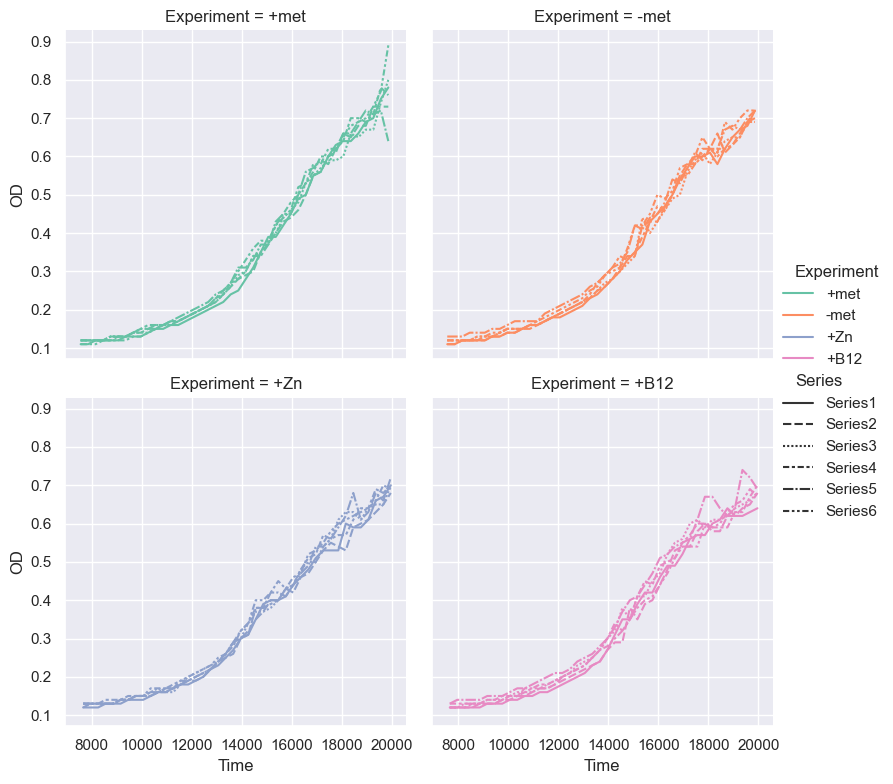

In [186]:
df_truncated = df.copy()

df_truncated.loc[df_truncated["Experiment"].isin(["+B12", "+Zn"]), "Time"] = df_truncated.loc[df_truncated["Experiment"].isin(["+B12", "+Zn"]), "Time"] +1000

df_truncated = df_truncated.loc[df_truncated["Time"].between(7500, 20000), :]



sns.relplot(x="Time", y="OD", hue="Experiment", style="Series", col="Experiment", kind="line", col_wrap=2, data=df_truncated, height=4
        )